In [2]:
import ase
import time
import sys
import torch
from torch.nn import MSELoss
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Checkpoint, EpochScoring
from skorch.callbacks.lr_scheduler import LRScheduler
from amptorch.gaussian import Gaussian
from amptorch.model import FullNN, CustomLoss, TanhLoss
from amptorch.data_preprocess import AtomsDataset, factorize_data, collate_amp, TestDataset
from md_work.md_utils import md_run, calculate_energies, calculate_forces, time_plots, kde_plots, md_run_old
from amptorch.skorch_model import AMP
from amptorch.skorch_model.utils import target_extractor, energy_score, forces_score
from amptorch.lj_new import lj_optim
from torch.utils.data import DataLoader
from torch.nn import init
from skorch.utils import to_numpy
import numpy as np
from ase import Atoms, units
from ase.calculators.emt import EMT

In [3]:
# define symmetry functions to be used
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 6.5

In [4]:
# Define Training data
%matplotlib inline

distances = []
energies = []
forces = []
distances = np.linspace(1, 5, 100)
images = []

label = "bond_example"
offset_atoms = Atoms("CuC", [(0, 0, 0), (0, 0, 1000000)])
offset_atoms.set_calculator(EMT())
e0 = offset_atoms.get_potential_energy()
for displacement in distances:
    atoms = Atoms("CuC", [(0, 0, 0), (0, 0, displacement)])
    atoms.set_cell([10, 10, 10])
    atoms.wrap(pbc=True)
    atoms.set_calculator(EMT())
    energy = atoms.get_potential_energy()
    force = atoms.get_forces()
    energies.append(energy)
    forces.append(force)
    images.append(atoms)

energies = np.array(energies)
forces = np.array([np.amax(np.abs(force)) for force in forces]).reshape(-1, 1)

# training_idx = np.array(random.sample(range(len(k)), 20))
training_idx = np.array([8, 10, 12, 14, 16, 18, 20, 22, 25, 27])
training_images = [images[i] for i in training_idx]
training_energies = energies[training_idx]
training_distances = distances[training_idx]

forcetraining = True
training_data = AtomsDataset(training_images, Gaussian, Gs, forcetraining=forcetraining,
        label=label, cores=4, lj_data=None)
unique_atoms = training_data.elements
fp_length = training_data.fp_length
device = "cpu"

Calculating fingerprints...
Fingerprints Calculated!


In [5]:
import skorch.callbacks.base

net = NeuralNetRegressor(
    module=FullNN(unique_atoms, [fp_length, 3, 10], device, forcetraining=forcetraining),
    criterion=CustomLoss,
    criterion__force_coefficient=0.3,
    optimizer=torch.optim.LBFGS,
    optimizer__line_search_fn="strong_wolfe",
    lr=1e-2,
    batch_size=10,
    max_epochs=100,
    iterator_train__collate_fn=collate_amp,
    iterator_train__shuffle=True,
    iterator_valid__collate_fn=collate_amp,
    device=device,
    train_split= 0,
    callbacks=[
        EpochScoring(
            forces_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ),
        EpochScoring(
            energy_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ),
    ],
)

In [6]:
calc = AMP(training_data, net, label)
calc.train()

  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          0.2012          3.2469       66.9755  0.1065
      2          0.2052          1.0453        7.7348  0.0734
      3          0.0979          0.2097        0.4761  0.0735
      4          0.0267          0.1112        0.0925  0.0732
      5          0.0247          0.0420        0.0238  0.0738
      6          0.0158          0.0313        0.0114  0.1316
      7          0.0099          0.0152        0.0035  0.1272
      8          0.0047          0.0092        0.0010  0.1292
      9          0.0042          0.0071        0.0007  0.1462
     10          0.0041          0.0060        0.0006  0.1435
     11          0.0041          0.0038        0.0004  0.1517
     12          0.0037          0.0028        0.0003  0.1599
     13          0.0036          0.0028        0.0003  0.1513
     14          0.0032          0.0021        0.0002  0.1379
     15 

In [7]:
ml_pred = [calc.get_potential_energy(image) for image in images]

In [8]:
# lj optimization
p0 = [2.29284676, 0.29639983, 1.33905162, 0.12290683]
params_dict = {"Cu": [], "C": []}
element_energies = {}
for element in ["C", "Cu"]:
    atoms = Atoms(element, cell=[20, 20, 20])
    atoms.set_calculator(EMT())
    element_energies[element] = atoms.get_potential_energy()

cutoff = 6.5
lj_model = lj_optim(training_images, p0, params_dict, cutoff, "test", element_energies)
fitted_params = lj_model.fit()
lj_energies, lj_forces, num_atoms = lj_model.lj_pred(training_images, fitted_params, params_dict)
lj_data = [lj_energies, lj_forces, num_atoms, fitted_params, params_dict, lj_model]
lj_model = lj_optim(images, p0, params_dict, cutoff, "test", element_energies)
lj_test, _, _ = lj_model.lj_pred(images, fitted_params, params_dict)


LJ optimization initiated...
Optimization terminated successfully.
         Current function value: 6.575513
         Iterations: 32
         Function evaluations: 58
Optimizer terminated successfully.


In [14]:
forcetraining = True
training_data = AtomsDataset(training_images, Gaussian, Gs, forcetraining=forcetraining,
        label=label, cores=4, lj_data=lj_data)
unique_atoms = training_data.elements
fp_length = training_data.fp_length
device = "cpu"

net = NeuralNetRegressor(
    module=FullNN(unique_atoms, [fp_length, 3, 10], device, forcetraining=forcetraining),
    criterion=CustomLoss,
    criterion__force_coefficient=0.3,
    optimizer=torch.optim.LBFGS,
    optimizer__line_search_fn="strong_wolfe",
    lr=1e-2,
    batch_size=10,
    max_epochs=100,
    iterator_train__collate_fn=collate_amp,
    iterator_train__shuffle=True,
    iterator_valid__collate_fn=collate_amp,
    device=device,
    train_split= 0,
    callbacks=[
        EpochScoring(
            forces_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ),
        EpochScoring(
            energy_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ),
    ],
)

calc = AMP(training_data, net, label)
calc.train()

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          0.1596          1.2612       20.2159  0.1226
      2          0.0947          0.5328        3.7857  0.1151
      3          0.0415          0.4287        2.2868  0.1179
      4          0.0467          0.3120        1.2621  0.1251
      5          0.0644          0.2186        0.7429  0.1264
      6          0.0382          0.1685        0.4011  0.1290
      7          0.0378          0.0916        0.1587  0.1340
      8          0.0133          0.0288        0.0171  0.1277
      9          0.0088          0.0137        0.0054  0.1521
     10          0.0046          0.0082        0.0017  0.1891
     11          0.0042          0.0077        0.0014  0.1600
     12          0.0031          0.0061        0.0008  0.1549
     13          0.0019          0.0047        0.0004  0.1552
     14          

In [15]:
mllj_pred = [calc.get_potential_energy(image) for image in images]

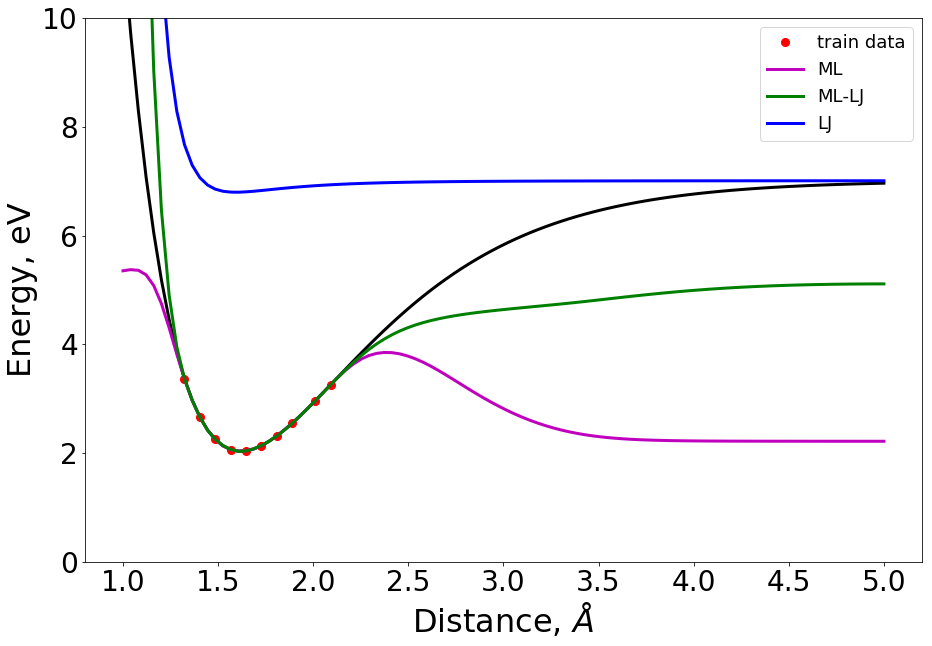

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_xlabel(r"Distance, $\AA$", fontsize=32)
ax1.set_ylabel("Energy, eV", color="k", fontsize=32)
ax1.plot(distances, energies, color="k", linewidth=3)
ax1.plot(training_distances, training_energies, "ro", label="train data", markersize=8)
ax1.plot(distances, ml_pred, "m", label="ML", linewidth=3)
ax1.plot(distances, mllj_pred, "g", label="ML-LJ", linewidth=3)
ax1.plot(distances, lj_test, "b", label="LJ", linewidth=3)
ax1.set_ylim(top=10)
ax1.set_ylim(bottom=0)
ax1.tick_params(axis="both", labelsize=28)
plt.legend(fontsize=18)
